In [39]:
from SyMBac.PSF import get_condensers, get_phase_contrast_kernel
from SyMBac.general_drawing import get_space_size, convolve_rescale
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from SyMBac.phase_contrast_drawing import draw_scene, generate_PC_OPL, make_images_same_shape
import pickle
from SyMBac.misc import get_sample_images
import numpy as np

cell_timeseries_properties_file = open("cell_timeseries_properties.p", "rb")
cell_timeseries_properties = pickle.load(cell_timeseries_properties_file)
cell_timeseries_properties_file.close()

main_segments_file = open("main_segments.p", "rb")
main_segments = pickle.load(main_segments_file)
main_segments_file.close()

In [71]:
condensers.keys()

dict_keys(['Ph1', 'Ph2', 'Ph3', 'Ph4', 'PhF'])

Text(0.5, 1.0, 'Phase contrast kernel')

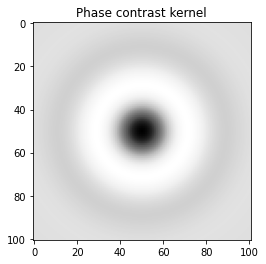

In [70]:
## Fixed parameters given by the scope and camera
condensers = get_condensers()
W, R, diameter = condensers["Ph3"]
radius = 50 #I've found 50 to be the best kernel size to optimise convolution speed while maintaining accuracy
λ = 0.75
resize_amount = 3
pix_mic_conv = 0.0655 #0.108379937 micron/pix for 60x, 0.0655 for 100x
scale = pix_mic_conv / resize_amount 
NA=1.45
n = 1.4

## Free parameters given by the undefined apodisation of the objective. 
## If unsure, leave this unchanged
min_sigma = 0.42*0.6/6 / scale #micron
sigma = min_sigma*14

kernel_params = (R,W,radius,scale,NA,n,sigma,λ) #Put into a tuple for easy use later
temp_kernel = get_phase_contrast_kernel(*kernel_params)
plt.imshow(temp_kernel, cmap="Greys_r")
plt.title("Phase contrast kernel")

In [3]:
do_transformation = True
offset = 30
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=13)(delayed(draw_scene)(
    cell_properties, do_transformation, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Scene Draw::   0%|          | 0/98 [00:00<?, ?it/s]

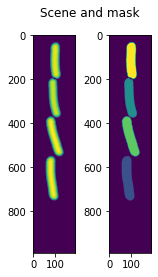

In [5]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2.5,4))
fig.suptitle('Scene and mask')
ax1.imshow(scenes[-1][0])
ax2.imshow(scenes[-1][1])
plt.show()

(256, 46)


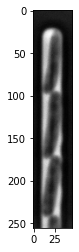

In [6]:
real_image = get_sample_images()["E. coli 100x"]
print(real_image.shape)
plt.imshow(real_image,cmap="Greys_r")
plt.show()

In [29]:
media_multiplier=30
cell_multiplier=1
device_multiplier=-50
y_border_expansion_coefficient = 1.9
x_border_expansion_coefficient = 1.4


temp_expanded_scene, temp_expanded_scene_no_cells, temp_expanded_mask = generate_PC_OPL(
   main_segments=main_segments,
    offset=offset,
    scene = scenes[-3][0],
    mask = scenes[-3][0],
    media_multiplier=media_multiplier,
    cell_multiplier=cell_multiplier,
    device_multiplier=cell_multiplier,
    y_border_expansion_coefficient = y_border_expansion_coefficient,
    x_border_expansion_coefficient = x_border_expansion_coefficient,
    fluorescence=False,
    defocus=30
)


### Generate temporary image to make same shape
temp_kernel = get_phase_contrast_kernel(*kernel_params)
convolved = convolve_rescale(temp_expanded_scene, temp_kernel, 1/resize_amount, rescale_int = True)
real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)

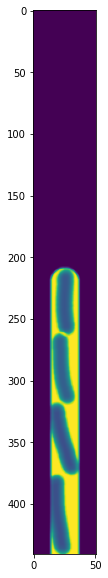

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(convolved)